# Introducción a la inferencia estadística
#IE09 Caso Práctico - Desafío para los Inversores


## <font color='blue'>**Un ejemplo práctico**</font>

### 1. El desafío para los inversores

Un desafío común al que se enfrenta un inversor es determinar si es probable que una acción cumpla con sus objetivos de inversión. Por ejemplo, considere a Pepe, un inversionista que busca comprar acciones seguras durante los próximos cinco años.

Al ser un inversor reacio al riesgo, solo se sentiría cómodo invirtiendo en una acción si ésta le brinda retornos mensuales preferiblemente no negativos en promedio y si puede estar razonablemente seguro de que su retorno mensual promedio no será inferior al -0,5%.

Pepe está muy interesado en las acciones de ITC (NSE: ITC), pero quiere asegurarse de que cumpla con su criterio. En tal caso, ¿existe algún marco teórico / estadístico que pueda ayudarla a llegar a una conclusión sobre el rendimiento mensual promedio de las acciones de ITC con cierta confianza?

¡La respuesta es sí! Y dicho marco estadístico se basa en el supuesto de la distribución de rendimiento, que a su vez se basa en el Teorema del Límite Central (CLT).

### 2. El supuesto de normalidad en las finanzas

En los modelos financieros, generalmente asumimos que la serie de precios tiene una distribución logarítmica normal y, por lo tanto, los rendimientos se distribuyen normalmente. Y así, para los inversores, que utilizan estos modelos para invertir, mucho depende de si el supuesto de normalidad se cumple o no en los mercados.

Echemos un vistazo a las acciones de ITC (NSE: ITC) en las que Pepe está interesado. Para realizar el análisis, primero importamos algunas bibliotecas estándar de Python y obtenemos los datos de acciones de ITC de Close-Close diarios de la biblioteca de finanzas.

In [1]:
!pip install yfinance
!pip install pyfolio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 950.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.0 MB/s eta 0:00:00
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88649 sha256=90debe2c869bcb92c919c3fd3f3f3aed2e58d1ffb603580e7d55619644d7c3ac
  Stored in directory: /root/.cache/pip/wheels/71/38/bc/e53700cfd8b0ad6b539d2fbaaf060ed8a299e7622a5b86ef42
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39754 sha256=97e8725bad2ad20a4753c0ed33b712e322f4cd89a26dab15b6023fe8cc089062
  Stored in directory: /root/.cache/pip/wheels/0e/2e/f2/d6d2d9a1eb8fbbd9949bb5d4c00f753e3b74e5bd7ed10b1d36
Successfully built pyfolio empyrical


In [2]:
# Librerias necesarias
import datetime as dt
import yfinance as yf
#import pyfolio as pf
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', None)

# Obtención de los datos de acciones del ITC de la biblioteca yfinance de los últimos 10 años
start = dt.datetime(2010,1,1).date()
end = dt.datetime(2020,12,31).date()
ITC = yf.download('ITC.NS',start, end)[['Adj Close']]

daily_data = ITC.copy().round(4)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Cálculo de retornos diarios
daily_data['daily_return']= np.log(daily_data['Adj Close']/daily_data['Adj Close'].shift())
daily_data.dropna(inplace=True)

# Echando un vistazo a los datos obtenidos
daily_data.head()

,Adj Close,daily_return
Date,,
2010-01-05,61.5894,0.009809
2010-01-06,61.7336,0.002339
2010-01-07,61.5413,-0.003120
2010-01-08,61.6735,0.002146
2010-01-11,61.6976,0.000391


Ahora que tenemos las retornos diarios de ITC (en escala logarítmica), en los siguientes diagramas visualizamos tanto los retornos como su distribución:

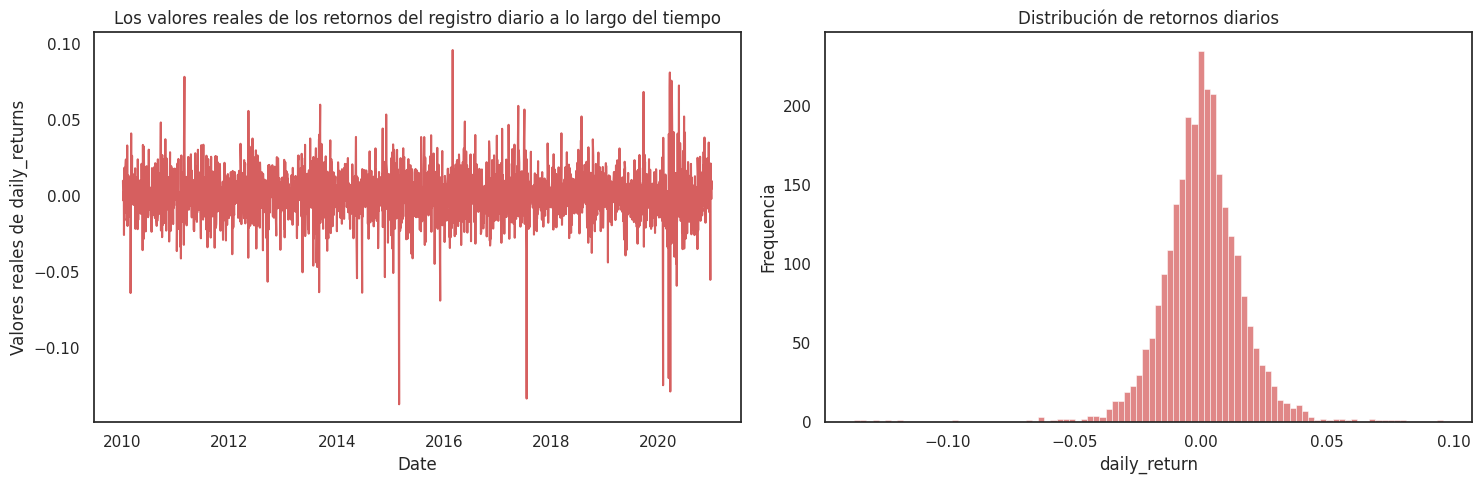

In [4]:
import matplotlib.pyplot as plt

# Visualización de los retornos del registro diario
sns.set(style="white", palette="muted", color_codes=True)
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
# Trace un histograma simple con el tamaño del bins determinado automáticamente
sns.lineplot(x=daily_data.index, y=daily_data['daily_return'], color="r")
plt.ylabel('Valores reales de daily_returns')
plt.title('Los valores reales de los retornos del registro diario a lo largo del tiempo')

plt.subplot(1,2,2)

sns.histplot(daily_data['daily_return'], kde=False, color="r")
plt.ylabel('Frequencia')


plt.tight_layout()
plt.title('Distribución de retornos diarios')

plt.show();

Podemos observar que en los diez años que estamos usando, el rendimiento diario de ITC se centra en 0. Sin embargo, en pocas ocasiones ha superado la marca del cinco por ciento al alza e incluso una marca negativa del diez por ciento a la baja. Esto explica la mayor **curtosis**, lo cual no es propio de una distribución normal.

Hasta ahora, nuestras conclusiones se basan en el análisis visual (muy recomendado como paso inicial). Para validarlos, necesitamos realizar una prueba estadística adecuada para verificar la normalidad/no normalidad de los datos, que es lo que haremos en la siguiente sección.

### 3. La prueba de Shapiro-Wilk
Podemos realizar una prueba estadística, la prueba de Shapiro-Wilk, para verificar la normalidad de los datos. Es la prueba más poderosa cuando se prueba una distribución normal.

La hipótesis nula plantea la normalidad de los datos. Si el valor $p$ es mayor que 0.01, asumimos una distribución normal con 99% de confianza, de lo contrario rechazamos la hipótesis nula.
<br>
$$H_0 : \text{La distribución de los datos es Normal}$$
$$H_a : \text{La distribución de los datos NO es Normal}$$
<br>

Ejecutamos la prueba mencionada anteriormente a continuación en los retornos de registro diarios usando la función `shapiro` de la biblioteca `scipy`:

In [5]:
from scipy.stats import shapiro
stat1, p1 = shapiro(daily_data['daily_return'])

if p1 < 0.01:
    test_result1 = 'No es Normal'
    print(f'El p-value es {p1:5.3e} < 0.01, por lo tanto se rechaza que los datos se distribuyen normalmente con un 99% de confianza.')
    print(test_result1)
else:
    test_result1 = 'Es Normal'
    print(f'El p-value es {p1:5.3e} < 0.01, por lo tanto asumimos que los datos estan distribuidos normalmente con un 99% de confianza. ')
    print(test_result1)

El p-value es 5.314e-35 < 0.01, por lo tanto se rechaza que los datos se distribuyen normalmente con un 99% de confianza.
No es Normal


### 4. El papel del Teorema del Límite Central

Recuerde que __TLC__ supone que X es una variable aleatoria (no necesariamente normal) que representa los datos de la población. Y que la distribución de
X, tiene una media de μ  y desviación estándar σ. Supongamos que estamos tomando muestras repetidas de tamaño _n_ de la población anterior. Entonces, para un tamaño de muestra _n_ suficientemente alto, las siguientes propiedades son verdaderas:

1. $$ \bar{x}\rightarrow N\left(\mu,\frac{\sigma}{\sqrt{n}}\right)$$

2. Pero

$$\bar{x} = \frac{x_1+x_2+..+x_n}{n}$$


3. Entonces

$$\frac{x_1+x_2+..+x_n}{n} \rightarrow N\left(\mu,\frac{\sigma}{\sqrt{n}}\right)$$

4. Por lo tanto

$$ [x_1+x_2+..+x_n] \rightarrow N(n\mu,\;\sigma\sqrt{n})$$

<br>
Por lo tanto, hemos demostrado que de acuerdo con el teorema del límite central, si $[x_1,x_2+..,x_n]$   es una muestra aleatoria de tamaño $n$ de una población de cualquier distribución, entonces la suma $[x_1+x_2+..+x_n]$ es tambien distribuida normalmente, dado un $n$ grande.

En nuestro caso, las muestras aleatorias repetidas no son más que rendimientos logarítmicos diarios consecutivos de la acción. Como los retornos de registros son de naturaleza aditiva, si tomamos muestras de los retornos de registros diarios para cada día de la semana (asumiendo que hay cinco días de negociación en la semana) y los sumamos, obtenemos el rendimiento semanal.

Del mismo modo, si sumamos los rendimientos del registro diario de todos los días de negociación en un mes, obtenemos el rendimiento mensual.

### 5. Prueba de la normalidad de las devoluciones semanales y mensuales

Uno de los aspectos principales al construir modelos financieros cuantitativos basados en los rendimientos de las acciones es que existe un proceso de generación de datos de población,  y estamos tomando muestras de esos datos.

Por ejemplo, asumimos que existe un proceso de generación de datos que genera retornos de acciones. Se desconocen los parámetros que definen la distribución de este proceso, pero es necesario estimarlos.

Si usamos retornos de registros diarios, estamos muestreando los datos al final de cada día de negociación del precio de cierre anterior. Por lo tanto, $x_1$
es el rendimiento del registro al final del primer día de negociación,
$x_2$ es el retorno del registro al final del segundo día de negociación y así sucesivamente. Ahora bien, si tomamos una muestra de $n$ días, tenemos una muestra de tamaño $n$. Ya hemos visto que las devoluciones de los registros diarios no se distribuyen normalmente.

Veamos qué sucede cuando analizamos los rendimientos semanales en lugar de los rendimientos diarios (es decir, aumentamos $n$ de 1 a 5).



In [6]:
# Remuestreo para obtener datos de cierre-cierre semanal y retorno semanal
weekly_data = ITC.resample('W').last()
weekly_data['weekly_return'] = np.log(weekly_data['Adj Close'] / weekly_data['Adj Close'].shift())
weekly_data.dropna(inplace=True)
weekly_data.head()

,Adj Close,weekly_return
Date,,
2010-01-17,60.771851,-0.014728
2010-01-24,59.894249,-0.014546
2010-01-31,60.146709,0.004206
2010-02-07,59.713905,-0.007222
2010-02-14,59.425385,-0.004843


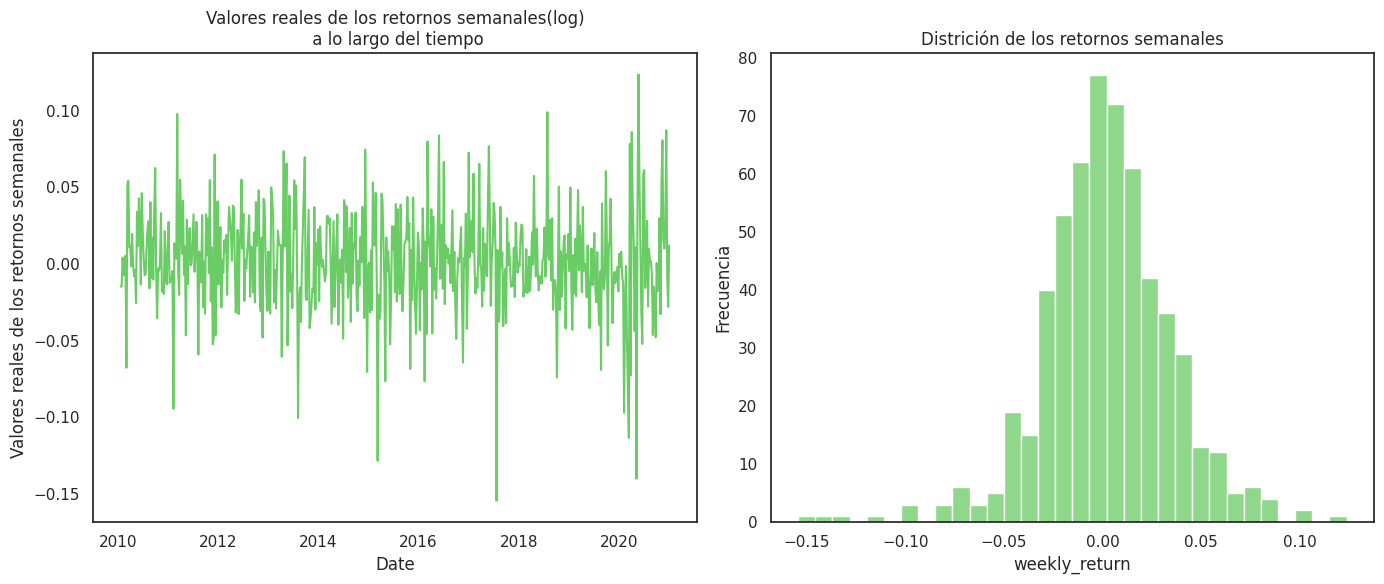

In [7]:
# Dibujando el valor actual y la distribución de retornos semanales.
sns.set(style="white", palette="muted", color_codes=True)
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.lineplot(x=weekly_data.index, y=weekly_data['weekly_return'], color="g")
plt.ylabel('Valores reales de los retornos semanales')
plt.title('Valores reales de los retornos semanales(log)\n a lo largo del tiempo')

plt.subplot(1,2,2)
sns.histplot(weekly_data['weekly_return'], kde=False, color="g")
plt.ylabel('Frecuencia')
plt.title('Districión de los retornos semanales')

plt.tight_layout()
plt.show();

In [8]:
from scipy.stats import shapiro
stat2, p2 = shapiro(weekly_data['weekly_return'])

if p2 < 0.01:
    test_result1 = 'No es Normal'
    print(f'El p-value es {p2:5.3e} < 0.01, por lo tanto se rechaza que los datos se distribuyen normalmente con un 99% de confianza.')
    print(test_result1)
else:
    test_result1 = 'Es Normal'
    print(f'El p-value es {p2:5.3e} < 0.01, por lo tanto asumimos que los datos estan distribuidos normalmente con un 99% de confianza. ')
    print(test_result1)

El p-value es 6.169e-09 < 0.01, por lo tanto se rechaza que los datos se distribuyen normalmente con un 99% de confianza.
No es Normal


Un valor p pequeño indica que, incluso cuando tomamos muestras a nivel semanal, los datos no son normales.

## <font color='green'>**Actividad 1**</font>
Verifique si los rendimientos mensuales (es decir, aumentando el tamaño de la muestra a 20) se distribuyen normalmente.

In [21]:
# Tu código aquí ...

# Remuestreo para obtener datos de cierre-cierre mensual y retorno mensual

monthly_data = ITC.resample('M').last()
monthly_data['monthly_return'] = np.log(monthly_data['Adj Close'] / monthly_data['Adj Close'].shift())
monthly_data.dropna(inplace=True)
monthly_data.head()

,Adj Close,monthly_return
Date,,
2010-02-28,55.842789,-0.074246
2010-03-31,63.248428,0.124530
2010-04-30,63.921650,0.010588
2010-05-31,68.093338,0.063221
2010-06-30,74.864487,0.094800


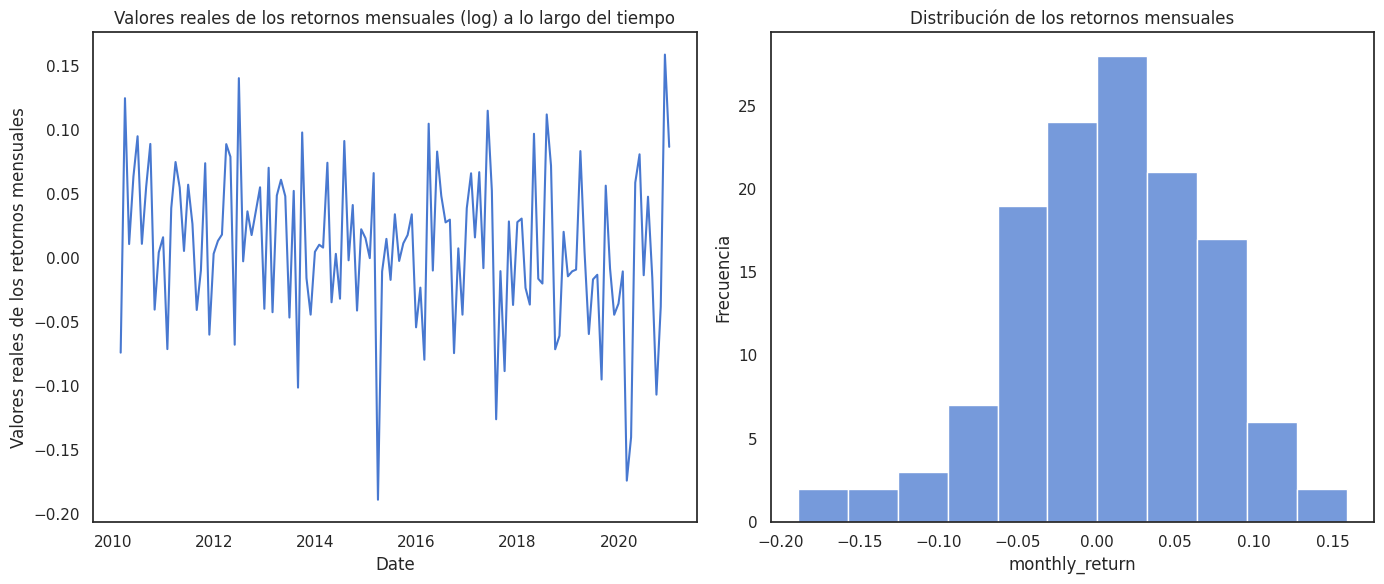

In [16]:
# Dibujando el valor actual y la distribucion de retornos mensuales.

sns.set(style="white", palette="muted", color_codes=True)
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.lineplot(x=monthly_data.index, y=monthly_data['monthly_return'], color="b")
plt.ylabel('Valores reales de los retornos mensuales')
plt.title('Valores reales de los retornos mensuales (log) a lo largo del tiempo')

plt.subplot(1,2,2)
sns.histplot(monthly_data['monthly_return'], kde=False, color="b")
plt.ylabel('Frecuencia')
plt.title('Distribución de los retornos mensuales')

plt.tight_layout()
plt.show();

In [17]:
# Test de normalidad

from scipy.stats import shapiro
stat3, p3 = shapiro(monthly_data['monthly_return'])

if p3 < 0.01:
    test_result3 = 'No es Normal'
    print(f'El p-value es {p3:5.3e} < 0.01, por lo tanto se rechaza que los datos se distribuyen normalmente con un 99% de confianza.')
    print(test_result3)
else:
    test_result3 = 'Es Normal'
    print(f'El p-value es {p3:5.3e} < 0.01, por lo tanto asumimos que los datos están distribuidos normalmente con un 99% de confianza.')
    print(test_result3)

El p-value es 2.706e-01 < 0.01, por lo tanto asumimos que los datos están distribuidos normalmente con un 99% de confianza.
Es Normal


<font color='green'>Fin actividad 1</font>

### 7. Intervalo de confianza

El __intervalo de confianza__ describe la variabilidad entre la medida obtenida en un estudio y la medida real de la población (el valor real). Corresponde a un rango de valores, cuya distribución es normal y en el cual se encuentra, con alta probabilidad, el valor real de una determinada variable. Esta _"alta probabilidad"_ se ha establecido por consenso en 95%. Así, un intervalo de confianza de 95% nos indica que dentro del rango dado se encuentra el valor real de un parámetro con 95% de certeza.

Volviendo al problema de inversión de Pepe, como podemos asumir con seguridad que los __rendimientos mensuales se distribuyen normalmente__, podemos utilizar el concepto estadístico de intervalos de confianza para obtener un rango de rendimiento mensual promedio con cierta confianza.

En general, bajo el supuesto de normalidad, el intervalo de confianza viene dado por:
<br><br>
$$ \bar{x} \pm z *\frac{s}{\sqrt{n}}$$
<br>
Donde $z$ es el _z-score_ asociado con un nivel determinado de confianza.

Entonces, si queremos obtener el intervalo de confianza del 95% para el rendimiento mensual promedio, ya que casi el 95% de los datos para una variable normal estándar se encuentra entre aproximadamente +/- 2 desviaciones estándar, el puntaje $z$ sería 1,96.

Además, como no conocemos la desviación estándar de la población $\sigma$, usaremos la desviación estándar de la muestra $s$ en su lugar.
En el siguiente código, calculamos el intervalo de confianza para el rendimiento mensual promedio:

In [12]:
from scipy import stats

In [13]:
z = stats.norm.ppf(0.05/2, loc=0, scale=1)
z

-1.9599639845400545

In [18]:
mean = np.mean(monthly_data['monthly_return'])

std = np.std(monthly_data['monthly_return'],ddof=1)/ np.sqrt(len(monthly_data))

#95% Intervalo de confianza.
upper = mean + z * std
lower = mean - z * std


CI_95 = (100 * np.round(lower, 3), 100 * np.round(upper, 3))
print(f'Estimación del rendimiento mensual medio: {100 * mean:4.3f}%') # Lo expresamos como por ciento
print(f'Intervalo de confianza del 95% para el rendimiento mensual medio en %: {CI_95}')


Estimación del rendimiento mensual medio: 0.868%
Intervalo de confianza del 95% para el rendimiento mensual medio en %: (1.9, -0.2)


In [19]:
mu, sigma = stats.norm.fit(monthly_data['monthly_return'])

Text(0.5, 1.0, 'Distribución Normal de datos mensualizados')

Text(51.5, 0.5, 'Densidad de probabilidad')

Text(0.5, 19.049999999999997, 'valores')

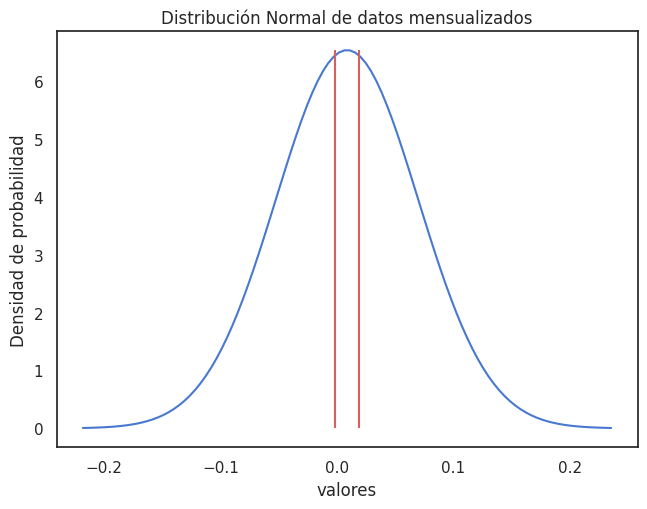

In [20]:
norm_m = stats.norm(mu, sigma)
x = np.linspace(norm_m.ppf(0.0001),
                norm_m.ppf(0.9999), 100)
fp = norm_m.pdf(x) # Función de Probabilidad
plt.plot(x, fp)
plt.vlines(lower, 0, max(fp), color='r')
plt.vlines(upper, 0, max(fp), color='r')
plt.tight_layout()
plt.title("Distribución Normal de datos mensualizados")
plt.ylabel("Densidad de probabilidad")
plt.xlabel("valores")

plt.show()

## <font color='purple'> __EXPERIMENTO__: </font>

## Evaluación de la Estacionalidad en los Rendimientos Mensuales.

Evaluar si hay algún patrón estacional en los rendimientos mensuales de las acciones de ITC.
La estacionalidad implica patrones recurrentes o tendencias que se repiten en ciertos períodos de tiempo.

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='Month', ylabel='monthly_return'>

Text(0.5, 1.0, 'Rendimientos Mensuales por Mes')

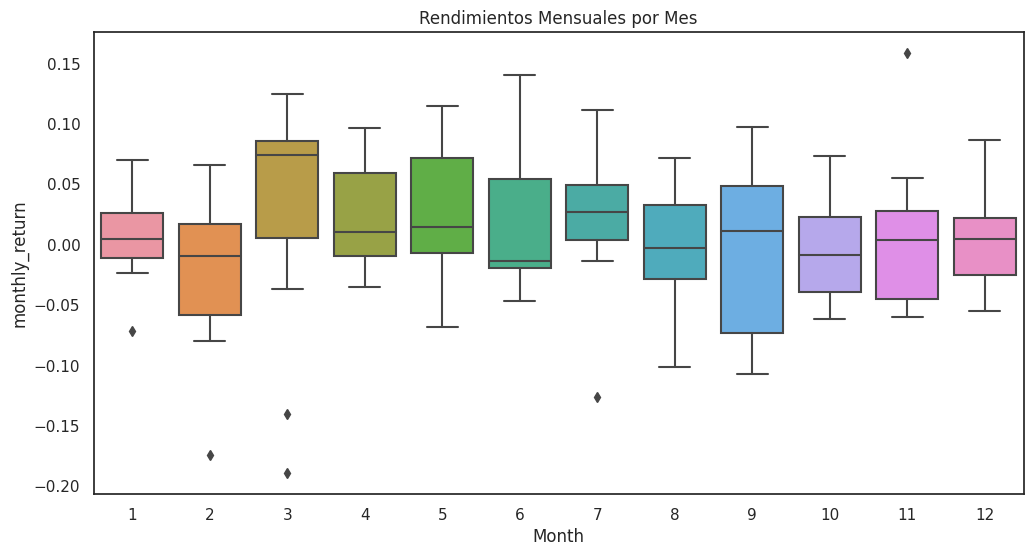

No hay evidencia de diferencias significativas entre los rendimientos mensuales de los meses.


In [24]:
# Dividir los datos mensuales en subconjuntos por mes
monthly_data['Month'] = monthly_data.index.month

# Visualizar rendimientos mensuales por mes
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='monthly_return', data=monthly_data)
plt.title('Rendimientos Mensuales por Mes')
plt.show()

# Realizamos el análisis de varianza (ANOVA) para evaluar diferencias entre los meses
from scipy.stats import f_oneway
result_anova, p_anova = f_oneway(
    monthly_data[monthly_data['Month'] == 1]['monthly_return'],
    monthly_data[monthly_data['Month'] == 2]['monthly_return'],
    monthly_data[monthly_data['Month'] == 3]['monthly_return'],
    monthly_data[monthly_data['Month'] == 4]['monthly_return'],
    monthly_data[monthly_data['Month'] == 5]['monthly_return'],
    monthly_data[monthly_data['Month'] == 6]['monthly_return'],
    monthly_data[monthly_data['Month'] == 7]['monthly_return'],
    monthly_data[monthly_data['Month'] == 8]['monthly_return'],
    monthly_data[monthly_data['Month'] == 9]['monthly_return'],
    monthly_data[monthly_data['Month'] == 10]['monthly_return'],
    monthly_data[monthly_data['Month'] == 11]['monthly_return'],
    monthly_data[monthly_data['Month'] == 12]['monthly_return']
)

if p_anova < 0.05:
    print('Hay diferencias significativas entre los rendimientos mensuales de al menos un par de meses.')
else:
    print('No hay evidencia de diferencias significativas entre los rendimientos mensuales de los meses.')


La prueba ANOVA no muestra evidencia de diferencias significativas entre los rendimientos mensuales de diferentes meses, esto podría indicar que no hay patrones estacionales fuertes o distintivos en los datos. Es posible que el comportamiento del mercado no muestre patrones repetitivos y predecibles en función del mes del año. Además de la estacionalidad, otros factores como la tendencia a largo plazo, la volatilidad y eventos específicos del mercado podrían ser más relevantes para entender y modelar el comportamiento de los rendimientos.

<font color='purple'>Fin experimento </font>

## <font color='purple'>__Material adicional__</font>

LECTURA

Curso de Fundamentos de Estadística y Análisis de Datos con Python

  https://github.com/francomanca93/fundamentos-de-estadistica-con-python <br> <br>



VIDEOS

Introducción a la inferencia estadística, Juan Sosa, 13-05-2022.

  https://www.youtube.com/watch?v=sRjCbUOJmQY <br> <br>


Estadística descriptiva e inferencial con Python: Construcción de Intervalos de Confianza, Ernesto Ponsot - PhD. in Statistics & Systems Engineering, 20-10-2022.

  https://www.youtube.com/watch?v=ZqPgKWTz9_g  <br> <br>


<font color='purple'>Fin material adicional </font>